# Imports & basic configuration

In [2]:
import os
import sys
# install the package if not yet installed
try:
    from branch.branch import Net
except:
    !python -m pip install git+https://github.com/nguwijy/deep_branching_with_domain.git
    from branch.branch import Net
import math
from scipy import special
import numpy as np
import torch
import matplotlib.pyplot as plt
import time
import logging
from pynverse import inversefunc
from branch.galerkin import DGMNet
from branch.bsde import BSDENet

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
# perfect reproducibility is not guaranteed with different version of torch
#
print(f"torch version: {torch.__version__}")

torch version: 1.13.1+cu117


In [3]:
print("Information of the allocated GPU.")
!nvidia-smi

Information of the allocated GPU.
Tue May 30 10:54:47 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 530.30.02              Driver Version: 530.30.02    CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                  Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA RTX A4000                On | 00000000:21:00.0 Off |                  Off |
| 41%   35C    P8               18W / 140W|    500MiB / 16376MiB |      0%      Default |
|                                         |                      |                  N/A |
+---------------------------------

In [4]:
# performance evaluation for PDE
def compare_performance(
    grid_1d,
    grid_nd,
    grid_with_t,
    t_lo,
    true,
    terminal,
    fname=None,
    debug_mode=False,
    disable_galerkin=False,
    disable_bsde=False,
    disable_branch=False,
    seeds=list(range(10)),
    disable_relative=False,
    **kwargs,
):
    if not os.path.isdir('logs/deep_branching/data/'):
        os.makedirs('logs/deep_branching/data/')
    if not os.path.isdir('logs/deep_branching/plot/'):
        os.makedirs('logs/deep_branching/plot/')
    x_lo, x_hi = grid_nd.min(), grid_nd.max()
    grid_nd = grid_nd.astype(np.float32)
    grid_with_t = grid_with_t.astype(np.float32)
    
    problem_name = fname
    fname = f"{fname}_dim_{grid_nd.shape[0]}" if fname is not None else None
    counter = 1

    branch_runtime, branch_l1_error, branch_l2_error, branch_rel_error, branch = (
        [],
        [],
        [],
        [],
        0,
    )
    branch_fdb_runtime, branch_total_runtime = [], []
    dgm_runtime, dgm_l1_error, dgm_l2_error, dgm_rel_error, dgm = [], [], [], [], 0
    bsde_runtime, bsde_l1_error, bsde_l2_error, bsde_rel_error, bsde = [], [], [], [], 0
    for seed in seeds:
        ######### Deep branching method
        if not disable_branch:
            torch.manual_seed(seed)
            print(
                f"#### Starting deep branching method with seed {seed} - {counter} out of {len(seeds)} times"
            )
            start = time.time()
            model = Net(t_lo=t_lo, t_hi=t_lo, x_lo=x_lo, x_hi=x_hi, problem_name=problem_name, **kwargs)
            model.train_and_eval(debug_mode)
            branch_total_runtime.append(time.time() - start)
            branch_fdb_runtime.append(model.fdb_runtime)
            branch_runtime.append(branch_total_runtime[-1] - branch_fdb_runtime[-1])
            # note that branch output batch_size x 1 instead of batch_size like other algo
            tmp = (
                model(torch.tensor(grid_with_t.T, device=device), patch=model.patches - 1)[:, 0].detach().cpu().numpy()
            )
            branch += tmp
            branch_l1_error.append((np.abs(tmp - true)).mean())
            branch_l2_error.append(((tmp - true) ** 2).mean())
            if not disable_relative:
                branch_rel_error.append((np.abs(tmp - true) / np.abs(true)).mean())
            else:
                branch_rel_error.append(0)
            print(
                f"Time taken: {branch_runtime[-1]:.0f} seconds; L1 error: {branch_l1_error[-1]:.2E}; L2 error: {branch_l2_error[-1]:.2E}; rel error: {branch_rel_error[-1]:.2E}."
            )
            print(
                f"fdb runtime: {branch_fdb_runtime[-1]:.0f} seconds; total runtime: {branch_total_runtime[-1]:.0f} seconds."
            )

        ######### Deep galerkin method
        if not disable_galerkin:
            torch.manual_seed(seed)
            print(
                f"#### Starting deep galerkin method with seed {seed} - {counter} out of {len(seeds)} times"
            )
            start = time.time()
            model = DGMNet(t_lo=t_lo, t_hi=kwargs["T"], x_lo=x_lo, x_hi=x_hi, **kwargs)
            model.train_and_eval(debug_mode)
            dgm_runtime.append(time.time() - start)
            tmp = (
                model(torch.tensor(grid_with_t.T, device=device)).detach().cpu().numpy()
            )
            dgm += tmp
            dgm_l1_error.append((np.abs(tmp - true)).mean())
            dgm_l2_error.append(((tmp - true) ** 2).mean())
            if not disable_relative:
                dgm_rel_error.append((np.abs(tmp - true) / np.abs(true)).mean())
            else:
                dgm_rel_error.append(0)
            print(
                f"Time taken: {dgm_runtime[-1]:.0f} seconds; L1 error: {dgm_l1_error[-1]:.2E}; L2 error: {dgm_l2_error[-1]:.2E}; rel error: {dgm_rel_error[-1]:.2E}."
            )

        ######### Deep BSDE method
        if not disable_bsde:
            torch.manual_seed(seed)
            print(
                f"#### Starting deep BSDE method with seed {seed} - {counter} out of {len(seeds)} times"
            )
            start = time.time()
            model = BSDENet(t_lo=t_lo, t_hi=kwargs["T"], x_lo=x_lo, x_hi=x_hi, **kwargs)
            model.train_and_eval(debug_mode)
            bsde_runtime.append(time.time() - start)
            tmp = (
                model(torch.tensor(grid_nd.T, device=device))
                .squeeze(-1)
                .detach()
                .cpu()
                .numpy()
            )
            bsde += tmp
            bsde_l1_error.append((np.abs(tmp - true)).mean())
            bsde_l2_error.append(((tmp - true) ** 2).mean())
            if not disable_relative:
                bsde_rel_error.append((np.abs(tmp - true) / np.abs(true)).mean())
            else:
                bsde_rel_error.append(0)
            print(
                f"Time taken: {bsde_runtime[-1]:.0f} seconds; L1 error: {bsde_l1_error[-1]:.2E}; L2 error: {bsde_l2_error[-1]:.2E}; rel error: {bsde_rel_error[-1]:.2E}."
            )

        print("\n")
        counter += 1

    # Plot
    f = plt.figure()
    plt.plot(grid_1d, true, label="True solution")
    plt.plot(grid_1d, terminal, label="Terminal condition")
    # save into csv
    if fname is not None:
        plt_data = np.stack((grid_1d, true, terminal), axis=-1)
        plt_header = "x, true, terminal"

    if not disable_branch:
        branch /= len(seeds)
        branch_runtime, branch_l1_error, branch_l2_error, branch_rel_error = (
            np.array(branch_runtime),
            np.array(branch_l1_error),
            np.array(branch_l2_error),
            np.array(branch_rel_error),
        )
        branch_fdb_runtime, branch_total_runtime = np.array(
            branch_fdb_runtime
        ), np.array(branch_total_runtime)
        print("\n")
        print("######## Summary for deep branching method")
        print(f"runtime:        {branch_runtime.mean():.0f}")
        print(f"fdb runtime:    {branch_fdb_runtime.mean():.0f}")
        print(f"total runtime:  {branch_total_runtime.mean():.0f}")
        print(f"mean L1 error:  {branch_l1_error.mean():.2E}")
        print(f"std L1 error:   {branch_l1_error.std():.2E}")
        print(f"mean L2 error:  {branch_l2_error.mean():.2E}")
        print(f"std L2 error:   {branch_l2_error.std():.2E}")
        print(f"mean rel error: {branch_rel_error.mean():.2E}")
        print(f"std rel error:  {branch_rel_error.std():.2E}")
        # Plot
        plt.plot(grid_1d, branch, label="Deep branching")
        # save into csv
        if fname is not None:
            plt_data = np.concatenate(
                (plt_data, np.expand_dims(branch, axis=-1)), axis=-1
            )
            plt_header += ", branch"
            data = np.stack(
                (branch_runtime, branch_l1_error, branch_l2_error, branch_rel_error),
                axis=-1,
            )
            np.savetxt(
                "logs/deep_branching/data/branch_" + fname + ".csv",
                data,
                delimiter=",",
                header="runtime,l1_error,l2_error,rel_error",
                comments="",
            )

    if not disable_galerkin:
        dgm /= len(seeds)
        dgm_runtime, dgm_l1_error, dgm_l2_error, dgm_rel_error = (
            np.array(dgm_runtime),
            np.array(dgm_l1_error),
            np.array(dgm_l2_error),
            np.array(dgm_rel_error),
        )
        print("\n")
        print("######## Summary for deep galerkin method")
        print(f"runtime:        {dgm_runtime.mean():.0f}")
        print(f"mean L1 error:  {dgm_l1_error.mean():.2E}")
        print(f"std L1 error:   {dgm_l1_error.std():.2E}")
        print(f"mean L2 error:  {dgm_l2_error.mean():.2E}")
        print(f"std L2 error:   {dgm_l2_error.std():.2E}")
        print(f"mean rel error: {dgm_rel_error.mean():.2E}")
        print(f"std rel error:  {dgm_rel_error.std():.2E}")
        # Plot
        plt.plot(grid_1d, dgm, label="Deep Galerkin")
        # save into csv
        if fname is not None:
            plt_data = np.concatenate((plt_data, np.expand_dims(dgm, axis=-1)), axis=-1)
            plt_header += ", dgm"
            data = np.stack(
                (dgm_runtime, dgm_l1_error, dgm_l2_error, dgm_rel_error), axis=-1
            )
            np.savetxt(
                "logs/deep_branching/data/dgm_" + fname + ".csv",
                data,
                delimiter=",",
                header="runtime,l1_error,l2_error,rel_error",
                comments="",
            )

    ######### Deep BSDE method
    if not disable_bsde:
        bsde /= len(seeds)
        bsde_runtime, bsde_l1_error, bsde_l2_error, bsde_rel_error = (
            np.array(bsde_runtime),
            np.array(bsde_l1_error),
            np.array(bsde_l2_error),
            np.array(bsde_rel_error),
        )
        print("\n")
        print("######## Summary for deep BSDE method")
        print(f"runtime:        {bsde_runtime.mean():.0f}")
        print(f"mean L1 error:  {bsde_l1_error.mean():.2E}")
        print(f"std L1 error:   {bsde_l1_error.std():.2E}")
        print(f"mean L2 error:  {bsde_l2_error.mean():.2E}")
        print(f"std L2 error:   {bsde_l2_error.std():.2E}")
        print(f"mean rel error: {bsde_rel_error.mean():.2E}")
        print(f"std rel error:  {bsde_rel_error.std():.2E}")
        # Plot
        plt.plot(grid_1d, bsde, label="Deep BSDE")
        # save into csv
        if fname is not None:
            plt_data = np.concatenate(
                (plt_data, np.expand_dims(bsde, axis=-1)), axis=-1
            )
            plt_header += ", bsde"
            data = np.stack(
                (bsde_runtime, bsde_l1_error, bsde_l2_error, bsde_rel_error), axis=-1
            )
            np.savetxt(
                "logs/deep_branching/data/bsde_" + fname + ".csv",
                data,
                delimiter=",",
                header="runtime,l1_error,l2_error,rel_error",
                comments="",
            )

    plt.legend()
    plt.show()
    f.savefig(f"logs/deep_branching/plot/{'comparison' if fname is None else fname}.pdf")
    if fname is not None:
        np.savetxt(
            "logs/deep_branching/data/plt_" + fname + ".csv", plt_data, delimiter=",", header=plt_header, comments=""
        )

In [6]:
def f_example(y, coordinate=0):
    """
    idx 0 -> no deriv
    idx 1 -> first deriv
    idx 2 -> second deriv
    """
    return ( y[0] - (2 + dim ) / 2 / dim ) * dim * y[1:(dim+1)].sum(dim=0) 
    
def dgm_f_example(y, coordinate=0):
    """
    idx 0 -> no deriv
    idx 1 -> first deriv
    idx 2 -> second deriv
    """
    return (( y[0] - (2 + dim ) / 2 / dim ) * dim * y[1:(dim+1)].sum(dim=0) + dim * dim * y[(dim+1):(2*dim+1)].sum(dim=0) / 2 )

def phi_example(x, coordinate=0):
    return torch.exp( T + x.sum(axis=0) / dim ) / (1 + torch.exp( T + x.sum(axis=0) / dim ) )
        
def exact_example(t, x, T):
    xi = t + x.sum(axis=0) / dim 
    return 1 / (1 + np.exp( - xi ) )

t_lo, x_lo, x_hi = 0., -5., 5.
    
x_mid = (x_lo + x_hi) / 2
grid = np.linspace(x_lo, x_hi, 100)

### Figure 4-a) with d=1 and T = 0.5

#### Starting deep branching method with seed 0 - 1 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 27 seconds; L1 error: 2.48E-03; L2 error: 1.00E-05; rel error: 3.89E-02.
fdb runtime: 0 seconds; total runtime: 27 seconds.
#### Starting deep galerkin method with seed 0 - 1 out of 10 times
Time taken: 79 seconds; L1 error: 1.29E-03; L2 error: 2.00E-06; rel error: 1.92E-02.
#### Starting deep BSDE method with seed 0 - 1 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 146 seconds; L1 error: 3.61E-03; L2 error: 2.05E-05; rel error: 5.97E-02.


#### Starting deep branching method with seed 1 - 2 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 27 seconds; L1 error: 3.21E-03; L2 error: 1.70E-05; rel error: 5.41E-02.
fdb runtime: 0 seconds; total runtime: 27 seconds.
#### Starting deep galerkin method with seed 1 - 2 out of 10 times
Time taken: 78 seconds; L1 error: 3.42E-04; L2 error: 2.01E-07; rel error: 1.08E-02.
#### Starting deep BSDE method with seed 1 - 2 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 148 seconds; L1 error: 4.83E-03; L2 error: 3.85E-05; rel error: 2.12E-02.


#### Starting deep branching method with seed 2 - 3 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 25 seconds; L1 error: 4.17E-03; L2 error: 5.56E-05; rel error: 3.07E-02.
fdb runtime: 0 seconds; total runtime: 25 seconds.
#### Starting deep galerkin method with seed 2 - 3 out of 10 times
Time taken: 86 seconds; L1 error: 4.02E-04; L2 error: 2.90E-07; rel error: 8.23E-03.
#### Starting deep BSDE method with seed 2 - 3 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 151 seconds; L1 error: 3.91E-03; L2 error: 2.39E-05; rel error: 6.81E-02.


#### Starting deep branching method with seed 3 - 4 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 25 seconds; L1 error: 3.20E-03; L2 error: 3.21E-05; rel error: 3.50E-02.
fdb runtime: 0 seconds; total runtime: 25 seconds.
#### Starting deep galerkin method with seed 3 - 4 out of 10 times
Time taken: 77 seconds; L1 error: 5.12E-04; L2 error: 3.25E-07; rel error: 8.19E-03.
#### Starting deep BSDE method with seed 3 - 4 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 147 seconds; L1 error: 2.80E-03; L2 error: 9.90E-06; rel error: 4.47E-02.


#### Starting deep branching method with seed 4 - 5 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 24 seconds; L1 error: 2.91E-03; L2 error: 1.66E-05; rel error: 5.07E-02.
fdb runtime: 0 seconds; total runtime: 24 seconds.
#### Starting deep galerkin method with seed 4 - 5 out of 10 times
Time taken: 73 seconds; L1 error: 1.63E-04; L2 error: 3.17E-08; rel error: 2.31E-03.
#### Starting deep BSDE method with seed 4 - 5 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 148 seconds; L1 error: 7.31E-03; L2 error: 6.34E-05; rel error: 1.16E-01.


#### Starting deep branching method with seed 5 - 6 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 23 seconds; L1 error: 2.14E-03; L2 error: 7.32E-06; rel error: 3.94E-02.
fdb runtime: 0 seconds; total runtime: 23 seconds.
#### Starting deep galerkin method with seed 5 - 6 out of 10 times
Time taken: 73 seconds; L1 error: 4.11E-04; L2 error: 2.75E-07; rel error: 1.11E-02.
#### Starting deep BSDE method with seed 5 - 6 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 147 seconds; L1 error: 2.35E-03; L2 error: 1.00E-05; rel error: 2.55E-02.


#### Starting deep branching method with seed 6 - 7 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 23 seconds; L1 error: 2.28E-03; L2 error: 8.74E-06; rel error: 4.68E-02.
fdb runtime: 0 seconds; total runtime: 23 seconds.
#### Starting deep galerkin method with seed 6 - 7 out of 10 times
Time taken: 79 seconds; L1 error: 4.56E-04; L2 error: 4.50E-07; rel error: 1.85E-02.
#### Starting deep BSDE method with seed 6 - 7 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 149 seconds; L1 error: 2.94E-03; L2 error: 1.33E-05; rel error: 5.35E-02.


#### Starting deep branching method with seed 7 - 8 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 27 seconds; L1 error: 2.82E-03; L2 error: 1.99E-05; rel error: 2.22E-02.
fdb runtime: 0 seconds; total runtime: 27 seconds.
#### Starting deep galerkin method with seed 7 - 8 out of 10 times
Time taken: 77 seconds; L1 error: 8.19E-04; L2 error: 8.82E-07; rel error: 2.25E-02.
#### Starting deep BSDE method with seed 7 - 8 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 144 seconds; L1 error: 4.05E-03; L2 error: 3.16E-05; rel error: 2.87E-02.


#### Starting deep branching method with seed 8 - 9 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 23 seconds; L1 error: 1.88E-03; L2 error: 6.32E-06; rel error: 2.20E-02.
fdb runtime: 0 seconds; total runtime: 23 seconds.
#### Starting deep galerkin method with seed 8 - 9 out of 10 times
Time taken: 79 seconds; L1 error: 3.61E-04; L2 error: 1.81E-07; rel error: 8.79E-03.
#### Starting deep BSDE method with seed 8 - 9 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 147 seconds; L1 error: 3.51E-03; L2 error: 1.83E-05; rel error: 3.13E-02.


#### Starting deep branching method with seed 9 - 10 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 21 seconds; L1 error: 2.47E-03; L2 error: 1.30E-05; rel error: 2.39E-02.
fdb runtime: 0 seconds; total runtime: 21 seconds.
#### Starting deep galerkin method with seed 9 - 10 out of 10 times
Time taken: 76 seconds; L1 error: 9.85E-04; L2 error: 1.36E-06; rel error: 2.24E-02.
#### Starting deep BSDE method with seed 9 - 10 out of 10 times
Time taken: 143 seconds; L1 error: 3.88E-03; L2 error: 1.74E-05; rel error: 5.93E-02.




######## Summary for deep branching method
runtime:        24
fdb runtime:    0
total runtime:  25
mean L1 error:  2.76E-03
std L1 error:   6.28E-04
mean L2 error:  1.87E-05
std L2 error:   1.43E-05
mean rel error: 3.64E-02
std rel error:  1.11E-02


######## Summary for deep galerkin method
runtime:        78
mean L1 error:  5.75E-04
std L1 error:   3.30E-04
mean L2 error:  6.00E-07
std L2 error:   5.99E-07
mean rel error: 1.32E-02
std rel error:  6.57E-03


######## Summary for deep BSDE method
runtime:        147
mean L1 error:  3.92E-03
std L1 err

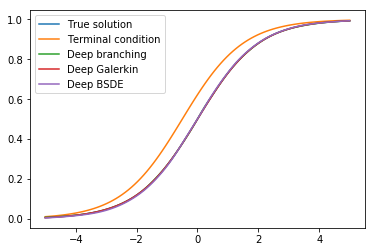

In [7]:
T = 0.5
dim = 1
grid_d_dim = np.concatenate((x_mid * np.ones((0, 100)), np.expand_dims(grid, axis=0), x_mid * np.ones((dim - 1, 100))), axis=0)
grid_d_dim_with_t = np.concatenate((t_lo * np.ones((1, 100)), grid_d_dim), axis=0)    
true = exact_example(t_lo, grid_d_dim, T)
terminal = exact_example(T, grid_d_dim, T)
deriv_map = np.concatenate((np.array([[0] * dim]), 1 * np.identity(dim), 2 * np.identity(dim)), axis=0).astype(int)

nu = dim ** 2

#grid, grid_d_dim, grid_d_dim_with_t, t_lo, true, terminal, \
#    f_example, deriv_map, phi_example, dgm_f_example = gen_for_generalized_burgers(n=n, T=T)
compare_performance(grid, grid_d_dim, grid_d_dim_with_t, t_lo, true, terminal=terminal, # seeds=[0],
                    # disable_bsde=True, disable_galerkin=True, verbose=True, debug_mode=True,
                    T=T, nu=nu, device=device, epochs=3000, fname=f"burger",
                    branch_nb_states=1000, branch_nb_path_per_state=3000,
                    branch_patches=1, branch_exponential_lambda=-math.log(.95)/T,
                    second_order=True, branch_nb_states_per_batch=200,
                    bsde_nb_states=1000, bsde_nb_time_intervals=4,
                    dgm_nb_states=1000, f_fun=f_example, dgm_f_fun=dgm_f_example,
                    deriv_map=deriv_map, dgm_deriv_map=deriv_map, phi_fun=phi_example,
                    outlier_percentile=3,
                    lr_gamma=0.1, branch_lr=1e-2, branch_activation="tanh", neurons=20, layers=5,
                    save_for_best_model=False, save_as_tmp=True)

### Figure 4-b) with d=15 and T = 0.1

In [ ]:
T = 0.1
dim = 15
grid_d_dim = np.concatenate((x_mid * np.ones((0, 100)), np.expand_dims(grid, axis=0), x_mid * np.ones((dim - 1, 100))), axis=0)
grid_d_dim_with_t = np.concatenate((t_lo * np.ones((1, 100)), grid_d_dim), axis=0)    
true = exact_example(t_lo, grid_d_dim, T)
terminal = exact_example(T, grid_d_dim, T)
deriv_map = np.concatenate((np.array([[0] * dim]), 1 * np.identity(dim), 2 * np.identity(dim)), axis=0).astype(int)

nu = dim ** 2

compare_performance(grid, grid_d_dim, grid_d_dim_with_t, t_lo, true, terminal=terminal, # seeds=[0],
                    # disable_bsde=True, disable_galerkin=True, verbose=True, debug_mode=True,
                    T=T, nu=nu, device=device, epochs=3000, fname=f"burger",
                    branch_nb_states=1000, branch_nb_path_per_state=1000,
                    branch_patches=1, branch_exponential_lambda=-math.log(.95)/T,
                    second_order=True, branch_nb_states_per_batch=200,
                    bsde_nb_states=1000, bsde_nb_time_intervals=4,
                    dgm_nb_states=1000, f_fun=f_example, dgm_f_fun=dgm_f_example,
                    deriv_map=deriv_map, dgm_deriv_map=deriv_map, phi_fun=phi_example,
                    outlier_percentile=3,
                    lr_gamma=0.1, branch_lr=1e-2, branch_activation="tanh", neurons=20, layers=5,
                    save_for_best_model=False, save_as_tmp=True)

#### Starting deep branching method with seed 0 - 1 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 171 seconds; L1 error: 1.02E-02; L2 error: 1.50E-04; rel error: 2.03E-02.
fdb runtime: 547 seconds; total runtime: 717 seconds.
#### Starting deep galerkin method with seed 0 - 1 out of 10 times
Time taken: 491 seconds; L1 error: 4.37E-02; L2 error: 2.67E-03; rel error: 9.19E-02.
#### Starting deep BSDE method with seed 0 - 1 out of 10 times
Time taken: 153 seconds; L1 error: 9.00E+00; L2 error: 9.70E+01; rel error: 1.85E+01.


#### Starting deep branching method with seed 1 - 2 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 174 seconds; L1 error: 5.87E-03; L2 error: 5.03E-05; rel error: 1.23E-02.
fdb runtime: 808 seconds; total runtime: 982 seconds.
#### Starting deep galerkin method with seed 1 - 2 out of 10 times
Time taken: 495 seconds; L1 error: 4.43E-02; L2 error: 2.75E-03; rel error: 9.33E-02.
#### Starting deep BSDE method with seed 1 - 2 out of 10 times
Time taken: 146 seconds; L1 error: 6.61E+00; L2 error: 4.54E+01; rel error: 1.32E+01.


#### Starting deep branching method with seed 2 - 3 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 173 seconds; L1 error: 9.26E-03; L2 error: 2.05E-04; rel error: 1.90E-02.
fdb runtime: 446 seconds; total runtime: 619 seconds.
#### Starting deep galerkin method with seed 2 - 3 out of 10 times
Time taken: 472 seconds; L1 error: 4.23E-02; L2 error: 2.50E-03; rel error: 8.89E-02.
#### Starting deep BSDE method with seed 2 - 3 out of 10 times
Time taken: 139 seconds; L1 error: 3.68E+00; L2 error: 1.61E+01; rel error: 7.13E+00.


#### Starting deep branching method with seed 3 - 4 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 179 seconds; L1 error: 1.13E-02; L2 error: 2.60E-04; rel error: 2.37E-02.
fdb runtime: 590 seconds; total runtime: 769 seconds.
#### Starting deep galerkin method with seed 3 - 4 out of 10 times
Time taken: 483 seconds; L1 error: 4.26E-02; L2 error: 2.55E-03; rel error: 8.97E-02.
#### Starting deep BSDE method with seed 3 - 4 out of 10 times
Time taken: 150 seconds; L1 error: 5.35E+00; L2 error: 3.25E+01; rel error: 1.10E+01.


#### Starting deep branching method with seed 4 - 5 out of 10 times


Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp
Logs are saved in /home/nprivault/NTU/nguwi_jiang_yu/deep_branching/deep_branching_with_domain/notebooks/logs/tmp


Time taken: 177 seconds; L1 error: 1.22E-02; L2 error: 2.78E-04; rel error: 2.47E-02.
fdb runtime: 631 seconds; total runtime: 808 seconds.
#### Starting deep galerkin method with seed 4 - 5 out of 10 times
